In [11]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [12]:
quandl.ApiConfig.api_key = 'tJKSQn1pHLbyo1mu1wYn'

gold = quandl.get('LBMA/GOLD')
silver = quandl.get('LBMA/SILVER')
oil = quandl.get('CHRIS/ICE_G6')
dollar = quandl.get('CHRIS/ICE_DX1')
dow_jones = quandl.get('BCB/UDJIAD1')
treasury = quandl.get('FRED/DGS10')


In [13]:
df = pd.merge(gold['USD (AM)'], silver['USD'], how='inner', on ='Date')
df = df.merge(oil['Settle'], on='Date', how='inner')
df = df.merge(dollar['Settle'], on = 'Date', how='inner')
df = df.merge(dow_jones, on='Date', how='inner')
df = df.merge(treasury, on='Date', how='inner')

df.rename(columns={'USD (AM)':'Gold',
                   'USD':'Silver',
                   'Settle_x':'Oil',
                   'Settle_y':'Dollar',
                   'Value_x':'Index',
                   'Value_y':'Interest'},
         inplace=True)

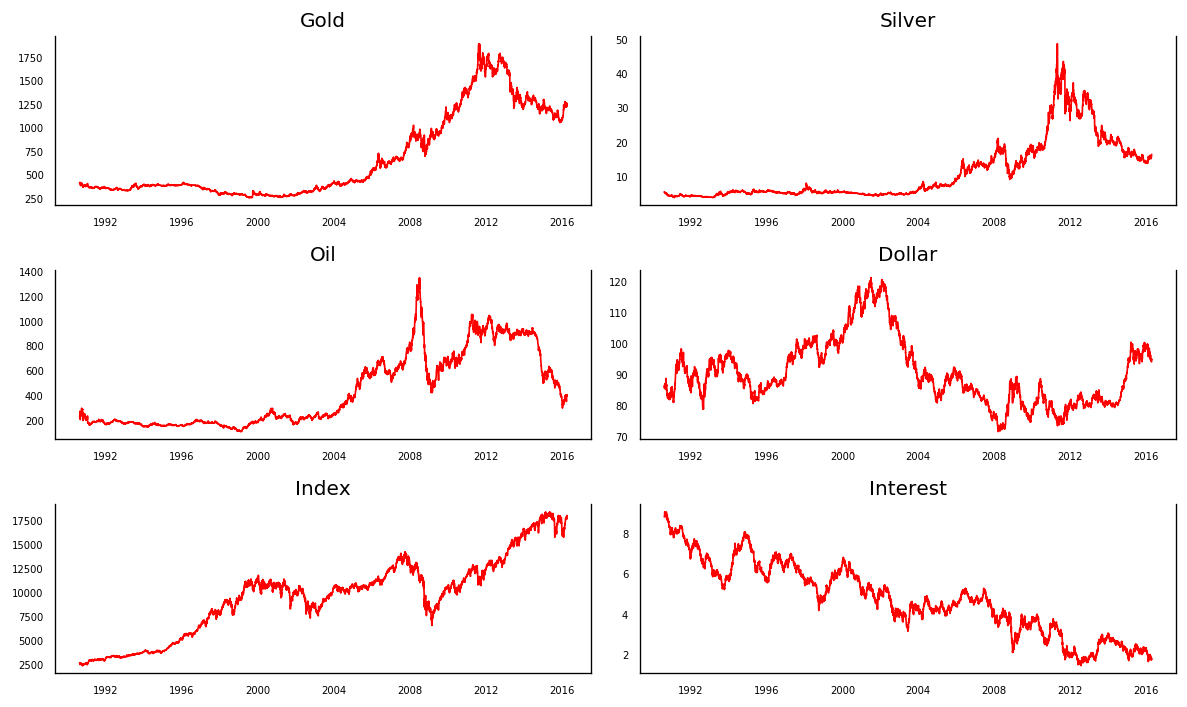

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();


In [17]:
from scipy import stats
stat, p = stats.normaltest(df.Gold)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=818.075, p=0.000
Data does not look Gaussian (reject H0)


In [18]:
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Gold)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Gold)))

Kurtosis of normal distribution: -0.40286830101520676
Skewness of normal distribution: 1.0061817027234357


In [19]:
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Oil)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Oil)))

Kurtosis of normal distribution: -0.8153115049736122
Skewness of normal distribution: 0.7392925075161445


count    6270.000000
mean      667.497520
std       449.475919
min       252.900000
25%       340.662500
50%       392.075000
75%      1062.812500
max      1891.000000
Name: Gold, dtype: float64

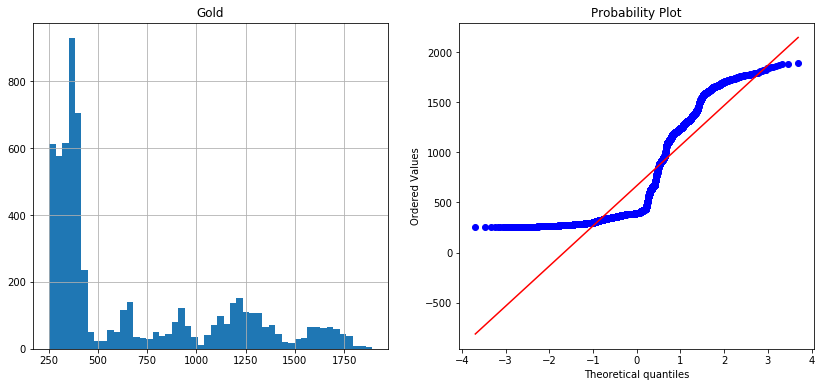

In [20]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Gold'].hist(bins=50)
plt.title('Gold')
plt.subplot(1,2,2)
stats.probplot(df['Gold'], plot=plt);
df.Gold.describe().T

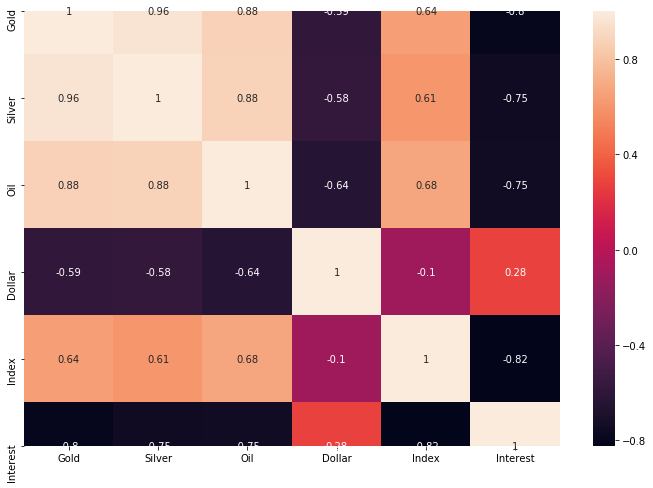

In [21]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot= True, annot_kws={'size':10})
heat_map=plt.gcf()
heat_map.set_size_inches(12, 8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


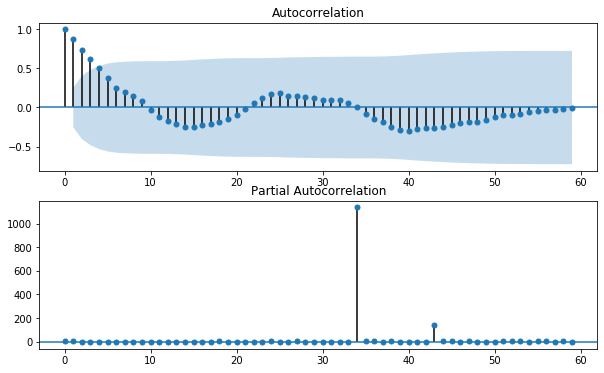

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig, ax = plt.subplots(2, figsize=(10,6))
ax[0] = plot_acf(df.Gold[:60], ax=ax[0])
ax[1] = plot_pacf(df.Gold[:60], ax=ax[1])

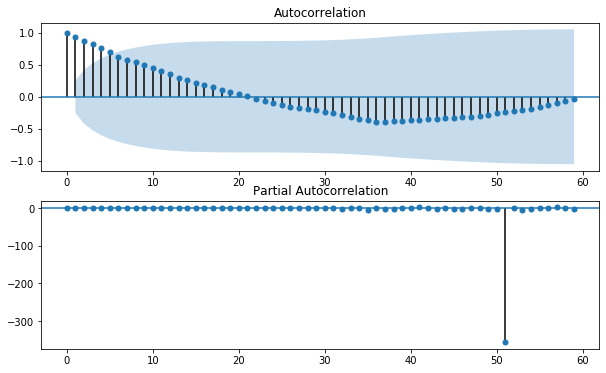

In [39]:
fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(df.Silver[:60], ax=ax[0])
ax[1] = plot_pacf(df.Silver[:60], ax=ax[1])

In [40]:
nobs = 15
X_train, X_test = df[0:-nobs], df[-nobs:]

#check size
print(X_train.shape)
print(X_test.shape)

(6255, 6)
(15, 6)


In [41]:
transform_data = X_train.diff().dropna()
transform_data.head()

,Gold,Silver,Oil,Dollar,Index,Interest
Date,,,,,,
1990-08-20,0.40,-0.0090,11.50,0.66,11.64,0.01
1990-08-21,-3.05,-0.0410,12.00,-0.01,-52.48,0.03
1990-08-22,2.15,-0.0435,7.00,-0.45,-43.81,0.07
1990-08-23,5.70,0.0995,17.00,-0.74,-76.73,0.09
1990-08-24,-3.70,-0.0820,-4.25,0.74,49.50,0.05


In [42]:
transform_data.describe()

,Gold,Silver,Oil,Dollar,Index,Interest
count,6254.000000,6254.000000,6254.000000,6254.000000,6254.000000,6254.000000
mean,0.131388,0.001658,0.026943,0.001643,2.375726,-0.001106
std,9.648393,0.364732,7.981583,0.508623,109.908635,0.059953
min,-133.500000,-6.680000,-59.500000,-3.250000,-777.680000,-0.510000
25%,-2.150000,-0.065000,-2.500000,-0.280000,-39.035000,-0.040000
50%,0.050000,0.000000,0.000000,0.000000,4.110000,0.000000
75%,2.600000,0.075000,2.750000,0.280000,49.947500,0.030000
max,80.750000,5.340000,92.250000,3.020000,889.350000,0.340000


In [44]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """ Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistics':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)
    
    # Print Summary
    print(f'   Augmented Dickey-Fuller Test on "{name}"', "\n  ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance level   = {signif}')
    print(f' Test Statistics      = {output["test_statistics"]}')
    print(f' No. Lags Chosen      = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f' Critical value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
          print(f" => Series is Stationary.")
          
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series in Non-Stationary.")
          
for name, column in transform_data.iteritems():
          adfuller_test(column, name=column.name)
          print('\n')
          

   Augmented Dickey-Fuller Test on "Gold" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -16.1413
 No. Lags Chosen      = 29
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Silver" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -13.5792
 No. Lags Chosen      = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Oil" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test St

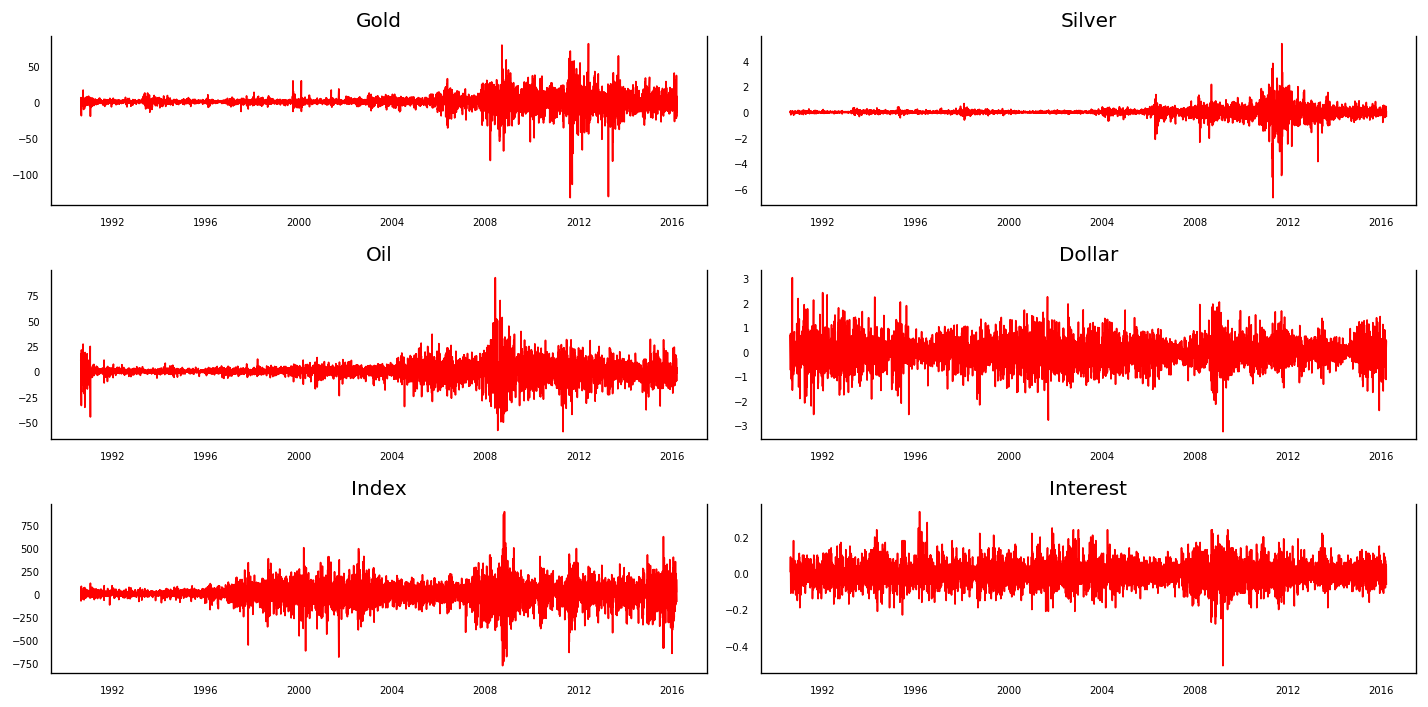

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    data = transform_data[transform_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(transform_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

In [66]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 5
test = 'ssr_chi2test'

def granger_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    X_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in X_train.columns:
        for r in X_train.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            X_train.loc[r, c] = min_p_value
    X_train.columns = [var + '_x' for var in variables]
    X_train.index = [var + '_y' for var in variables]
    return X_train

granger_causation_matrix(X_train, variables = X_train.columns)

,Gold_x,Silver_x,Oil_x,Dollar_x,Index_x,Interest_x
Gold_y,1.0000,0.0000,0.0000,0.0000,0.0324,0.0000
Silver_y,0.0220,1.0000,0.0000,0.0000,0.0000,0.1072
Oil_y,0.0022,0.0023,1.0000,0.0443,0.0000,0.0001
Dollar_y,0.1705,0.4860,0.4890,1.0000,0.0000,0.0266
Index_y,0.0218,0.1789,0.0980,0.1669,1.0000,0.0070
Interest_y,0.0142,0.0332,0.0196,0.7063,0.0019,1.0000


In [68]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(transfrom_data, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(transform_data, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6):
        return str(val).ljust(length)
    
    # Summary
    print('Name   :: Test Stat > C(95%)       => Signif   \n', '--'*20)
    for col, trace, cvt in zip(transform_data.columns, traces, cvts):
        print(adjust(col), '::', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), '  =>  ', trace >cvt)
        

cointegration_test(X_train)

Name   :: Test Stat > C(95%)       => Signif   
 ----------------------------------------
Gold   :: 6179.08   > 83.9383    =>   True
Silver :: 5032.19   > 60.0627    =>   True
Oil    :: 3908.61   > 40.1749    =>   True
Dollar :: 2807.14   > 24.2761    =>   True
Index  :: 1786.0    > 12.3212    =>   True
Interest :: 886.39    > 4.1296     =>   True


In [69]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
mod = smt.VAR(transform_data)
res = mod.fit(maxlags= 5, ic = 'aic')
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2019
Time:                     16:57:04
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    8.13398
Nobs:                     6253.00    HQIC:                   8.10439
Log likelihood:          -78483.1    FPE:                    3257.45
AIC:                      8.08870    Det(Omega_mle):         3235.66
--------------------------------------------------------------------
Results for equation Gold
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.133987         0.119261            1.123           0.261
L1.Gold            -0.111176         0.017345           -6.410           0.000
L1.Silver           1.540596         0.462076            3.334       

In [70]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)

for col, val in zip(transform_data.columns, out):
    print((col), ':', round(val, 2))

Gold : 2.0
Silver : 2.0
Oil : 2.0
Dollar : 2.0
Index : 2.0
Interest : 2.0


In [72]:
pred = res.forecast(transform_data.values[-3:], 15)
pred_df = pd.DataFrame(pred, index=df.index[-15:], columns = df.columns)
pred_df

,Gold,Silver,Oil,Dollar,Index,Interest
Date,,,,,,
2016-03-24,0.497139,-0.033003,-1.749110,0.011469,1.308592,-0.004692
2016-03-29,-0.156231,-0.005410,-0.023090,-0.000524,3.050843,-0.001026
2016-03-30,0.150506,0.003133,0.018828,0.001682,2.226775,-0.001159
2016-03-31,0.131363,0.001329,0.024463,0.001576,2.386065,-0.001106
2016-04-01,0.130771,0.001696,0.024798,0.001532,2.375389,-0.001108
2016-04-04,0.131609,0.001647,0.024813,0.001545,2.373597,-0.001109
2016-04-05,0.131414,0.001652,0.024808,0.001543,2.374432,-0.001109
2016-04-06,0.131445,0.001652,0.024811,0.001543,2.374251,-0.001109
2016-04-07,0.131442,0.001652,0.024810,0.001543,2.374279,-0.001109


In [73]:
pred_inverse = pred_df.cumsum()
f = pred_inverse + X_test
print(f)

                   Gold     Silver         Oil     Dollar         Index  \
Date                                                                      
2016-03-24  1216.947139  15.246997  383.250890  96.184469  17517.038592   
2016-03-29  1216.790907  15.021587  367.477801  95.156945  17637.469435   
2016-03-30  1238.691414  15.344720  375.746629  94.831628  17723.246210   
2016-03-31  1234.222776  15.346049  378.771092  94.592203  17694.062275   
2016-04-01  1232.853548  15.347745  360.295890  94.633735  17804.097664   
2016-04-04  1215.885157  14.929393  355.070703  94.541280  17750.721260   
2016-04-05  1232.516571  15.161044  344.345512  94.655823  17619.415692   
2016-04-06  1226.898016  15.042696  356.620323  94.461366  17734.519944   
2016-04-07  1238.779458  15.194348  350.645133  94.525909  17562.804222   
2016-04-08  1236.410900  15.135999  377.919943  94.275452  17600.178498   
2016-04-11  1248.792342  15.537651  382.944753  93.966995  17582.002774   
2016-04-12  1260.873784  

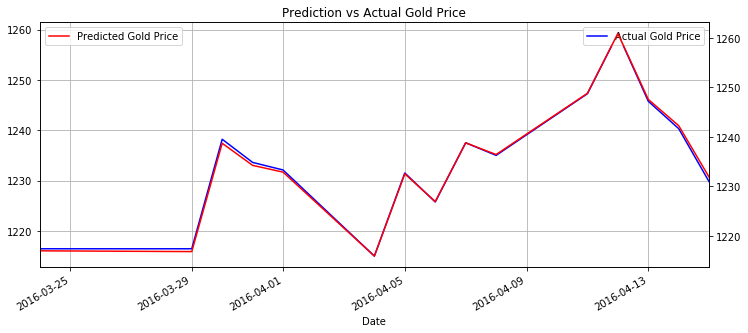

In [74]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = X_test.Gold.plot(color='blue', grid=True, label='Actual Gold Price')
ax2 = f.Gold.plot(color='red', grid=True, secondary_y=True, label='Predicted Gold Price')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Prediction vs Actual Gold Price')
plt.show()

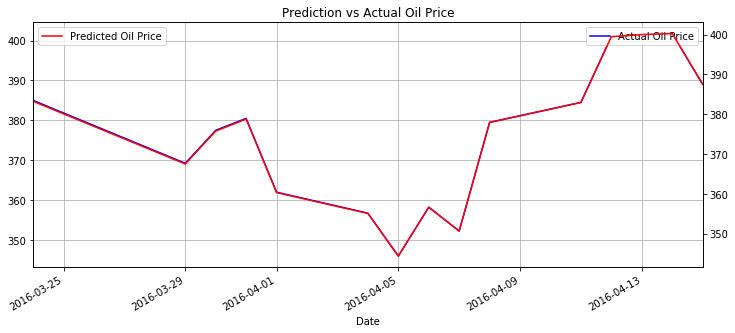

In [75]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = X_test.Oil.plot(color='blue', grid=True, label='Actual Oil Price')
ax2 = f.Oil.plot(color='red', grid=True, secondary_y=True, label='Predicted Oil Price')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Prediction vs Actual Oil Price')
plt.show()

In [76]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

forecast_errors = [X_test.Gold[i]-f.Gold[i] for i in range(len(X_test.Gold))]
bias = sum(forecast_errors) * 1.0/len(X_test.Gold)
print('Bias: %f' % bias)

mae = mean_absolute_error(X_test.Gold, f.Gold)
print('MAE: %f' % mae)

mse = mean_squared_error(X_test.Gold, f.Gold)
print('MSE: %f' % mse)

rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -1.164801
MAE: 1.164801
MSE: 1.652667
RMSE: 1.285561


In [77]:
forecast_errors = [X_test.Oil[i]-f.Oil[i] for i in range(len(X_test.Oil))]
bias = sum(forecast_errors) * 1.0/len(X_test.Oil)
print('Bias: %f' % bias)

mae = mean_absolute_error(X_test.Oil, f.Oil)
print('MAE: %f' % mae)

mse = mean_squared_error(X_test.Oil, f.Oil)
print('MSE: %f' % mse)

rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 1.625614
MAE: 1.625614
MSE: 2.652907
RMSE: 1.628775
